In [1]:
import tensorflow as tf
tf.__version__

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'2.0.0-alpha0'

In [2]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Softmax, Conv1D, GlobalMaxPool1D, Embedding
from tensorflow.keras.layers import Dropout, Concatenate, Softmax

In [3]:
class TextCNN(keras.Model):
    
    def __init__(self, max_len=100, vocab_size=5000, embed_size=128, 
                 kernel_size=None, filters=128, n_class=2, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.n_class = n_class
        self.kernel_size = kernel_size or [3, 4, 5]
        # Number of filters for each kernel size
        self.filters = filters
    
        self.embedding = Embedding(self.vocab_size, self.embed_size, input_length=self.max_len)
        self.dense = Dense(self.n_class, activation='softmax')
        
    def multisize_conv(self, X):
        """ Performs a Conv1D operation on the embedding with different kernel sizes,
            and concatenate the result.
        """
        output = []
        
        for kernel_size in self.kernel_size:
            conv = Conv1D(self.filters, kernel_size, activation='relu')
            setattr(self, 'conv1d_{}'.format(kernel_size), conv)
            x = conv(X)  # [batch_size, max_len - kernel_size, filters]
            x = GlobalMaxPool1D()(x)  # [batch_size, filters]
            output.append(x)
    
        return keras.layers.concatenate(output)  # [batch_size, filters * number of kernels]
    
    def call(self, X):
        x = self.embedding(X)
        x = self.multisize_conv(x)
        output = self.dense(x)
        return output

# Test the model against the IMDB dataset

In [4]:
import sys
sys.path.append('../')

from utils.datasets import create_imdb_dataset

In [5]:
N_VOCAB = 5000
MAX_LEN = 100
BATCH_SIZE = 32
EMBED_SIZE = 128

train_dataset, test_dataset = create_imdb_dataset(n_vocab=N_VOCAB,
                                                 max_len=MAX_LEN,
                                                 batch_size=BATCH_SIZE)

In [17]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

textCNN = TextCNN(max_len=MAX_LEN,
                 vocab_size=N_VOCAB,
                 embed_size=EMBED_SIZE)

textCNN.compile(optimizer=Adam(), 
                loss=CategoricalCrossentropy(from_logits=True), 
                metrics=['accuracy'])

In [18]:
# train the model for 10 epoches
history = textCNN.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
782/782 [==============================] - 41s 53ms/step - loss: 0.5658 - accuracy: 0.6825 - val_loss: 0.4872 - val_accuracy: 0.8328
Epoch 2/10
782/782 [==============================] - 23s 29ms/step - loss: 0.4483 - accuracy: 0.8570 - val_loss: 0.4606 - val_accuracy: 0.8549
Epoch 3/10
782/782 [==============================] - 22s 28ms/step - loss: 0.3959 - accuracy: 0.9242 - val_loss: 0.4516 - val_accuracy: 0.8606
Epoch 4/10
782/782 [==============================] - 23s 29ms/step - loss: 0.3607 - accuracy: 0.9622 - val_loss: 0.4471 - val_accuracy: 0.8627
Epoch 5/10
782/782 [==============================] - 26s 34ms/step - loss: 0.3404 - accuracy: 0.9798 - val_loss: 0.4450 - val_accuracy: 0.8615
Epoch 6/10
782/782 [==============================] - 22s 28ms/step - loss: 0.3302 - accuracy: 0.9874 - val_loss: 0.4434 - val_accuracy: 0.8636
Epoch 7/10
782/782 [==============================] - 21s 27ms/step - loss: 0.3247 - accuracy: 0.9922 - val_loss: 0.4422 - val_accuracy:

In [45]:
# plot the training information
from utils.plotting import plot_training_history

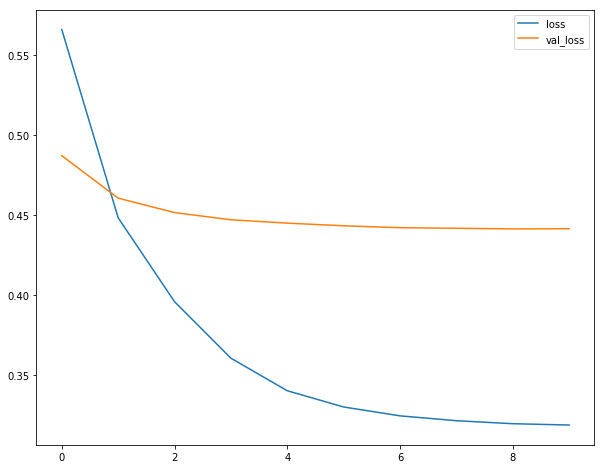

In [46]:
plot_training_history(history, keyword='loss')

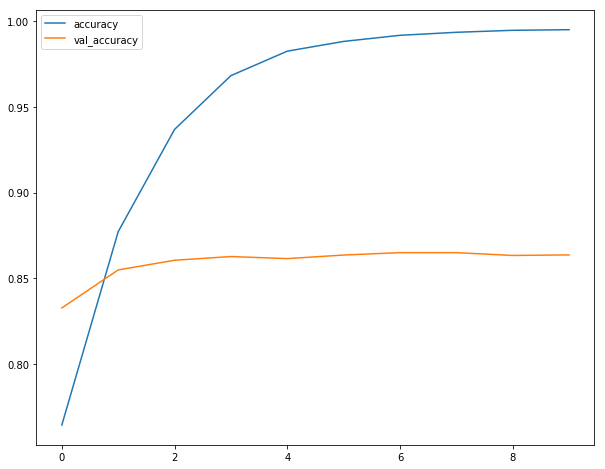

In [47]:
plot_training_history(history, keyword='accuracy')